In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Representation of pulse trains

* *negative* integers --> length of time spent in the "0" state 
* *positive* integers --> length of time spent in the "1" state

In [13]:
def expand(wav):
    ## Expand from delta form to wav form
    ## using the signed delta convention
    expanded = []
    t = 0
    ts = []
    for width in wav:
        assert(width == int(width))
        ele = (np.sign(width)+1)/2 
        abs_width =np.abs(width)
        expanded += (abs_width+1)*[ele]
        ts += [t+i for i in range(abs_width+1)]
        t += abs_width
    return ts,expanded

def expand_new_pulse(t_start,t_width):
    assert(t_start == int(t_start))
    assert(t_width == int(t_width))
    assert(t_start >= 0)
    assert(t_width > 0)
    
    ts=[t_start]
    expanded = [0]
    
    ts+= list(range(t_start,t_start+t_width+1))
    expanded+= [1]*(t_width+1)
    
    ts.append(t_start+t_width)
    expanded.append(0)
    
    return ts, expanded

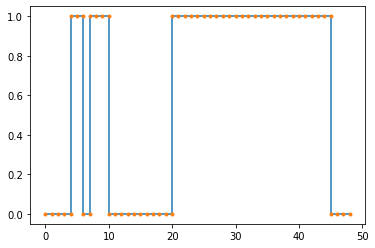

In [14]:
pulse_stream = [-4,2,-1,3,-10,25,-3]
ts,expanded = expand(pulse_stream)
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()

48

In [91]:
from typing import Union,List
class nested_pulse_train:
    
    def __init__(self, pulses: List[Union[int,nested_pulse_train]] ):
        self.pulses = pulses
        self.compute_duration()
        
    def __str__(self):
        string = "nested_pulse_train( [ "
        for ele in self.pulses:
            if isinstance(ele,int):
                string += f"{ele}, "
            else:
                string += str(ele)
        
        string += "] ) "
        return string
    
    def compute_duration(self):
        """
        Total duration of all nested pulse train components
        """
        accumulator = 0
        for ele in self.pulses:
            if isinstance(ele,int):
                accumulator += np.abs(ele)
            else:
                accumulator += ele.compute_duration()
        self.duration = accumulator
        return self.duration
    
    def expand(self,t_offset = 0):
        """
        Return a list that is suitable for plotting pulse trains
        Do not plot, just return the lists
        """
        expanded = []
        t = t_offset
        ts = []
        for pulse in self.pulses:
            if isinstance(pulse,int):
                ele = (np.sign(pulse)+1)/2 
                duration =np.abs(pulse)
                expanded += (duration+1)*[ele]
                ts += [t+i for i in range(duration+1)]
                t += duration
            else:
                ts_nested,expanded_nested = pulse.expand(t_offset = t)
                ts += ts_nested
                expanded += expanded_nested
                t += pulse.duration
        return ts,expanded

    def add_pulse(self,t_start: int, t_width:int):
        assert( t_start > 0)
        assert( t_width > 0)
        pass
    
    def consolidate(self):
        sign = None
        sign_changed = False
        do_consolidate = True
        for (idx,pulse) in enumerate(self.pulses):
            
            if not isinstance(pulse,int):
                if (pulse.consolidate()):
                    self.pulses[idx] = int(pulse.pulses[0])
                    pulse = self.pulses[idx]
            
            # Initialize sign
            if sign is None:
                sign = np.sign(pulse)
            
            #if there are any sign changes, cannot fully consolidate
            if (sign != np.sign(pulse)) and (not sign_changed):
                sign_chaged = True
                do_consolidate = False
        if do_consolidate:
            self.pulses = [sign*self.duration]
            return True
        else: 
            return False
            

nested_pulse_train( [ -4, 2, -1, 3, -10, 25, -3, ] ) 
48
detected sign change!
detected sign change!
detected sign change!


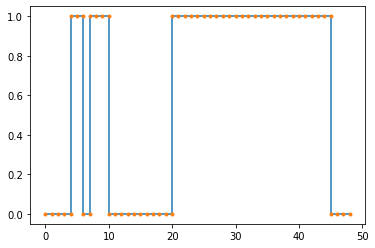

nested_pulse_train( [ -10, 10, -10, 30, nested_pulse_train( [ 2, 2, 6, -10, ] ) 10, ] ) 
90


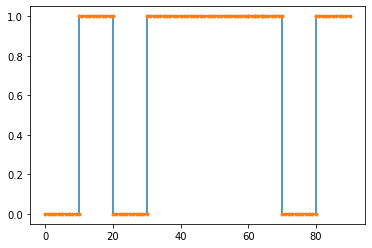

nested_pulse_train( [ -10, 10, -10, nested_pulse_train( [ 10, 10, 10, nested_pulse_train( [ 1, 1, 1, 1, ] ) ] ) 10, ] ) 
detected sign change!
detected nesting
detected nesting
detected sign change!
detected sign change!
nested_pulse_train( [ -10, 10, -10, 34, 10, ] ) 


In [96]:
pulse_stream = [-4,2,-1,3,-10,25,-3]
example = nested_pulse_train(pulse_stream)
example.compute_duration()
print(example)
print(example.duration)
ts,expanded = example.expand()
example.consolidate()
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()

example2 = nested_pulse_train( [-10,10,-10,30, nested_pulse_train([2,2,6,-10]),10 ]  )
print(example2)
example2.compute_duration()
print(example2.duration)
ts,expanded = example2.expand()
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()


consolidation_test = nested_pulse_train([-10,10,-10,nested_pulse_train([10,10,10,nested_pulse_train([1,1,1,1])]),10])
print(consolidation_test)
consolidation_test.consolidate()
print(consolidation_test)

In [93]:
for pulse in consolidation_test.pulses:
    print(f"{pulse=}, {type(pulse)=}")

pulse=-10, type(pulse)=<class 'int'>
pulse=10, type(pulse)=<class 'int'>
pulse=-10, type(pulse)=<class 'int'>
pulse=30, type(pulse)=<class 'int'>
pulse=10, type(pulse)=<class 'int'>


In [45]:
def partial_cum_sum(pulse_stream,t_start,t_width):
    ## Find where the new pulse lies in the existing stream
    j = 0
    cum_sum=[pulse_stream[0]]
    while ( cum_sum[j] <= t_start+t_width ):
        cum_sum.append(cum_sum[j]+pulse_stream[j+1])
        j+=1
    return np.array(cum_sum)

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20])
leading_edge_idx=4
leading_delta=2


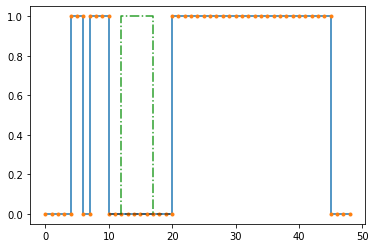

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20])
leading_edge_idx=3
leading_delta=2


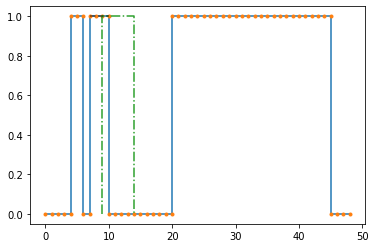

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20])
leading_edge_idx=3
leading_delta=3


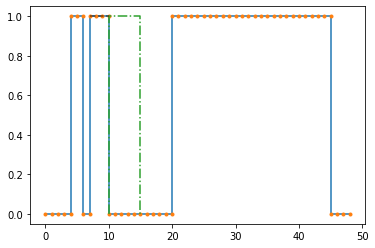

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=4
leading_delta=8


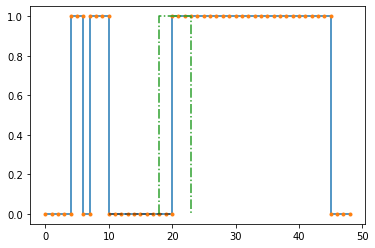

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=4
leading_delta=5


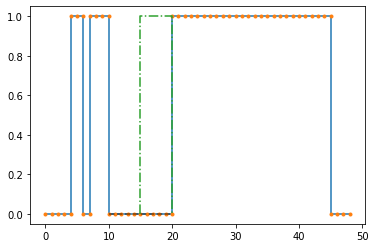

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=3
leading_delta=2


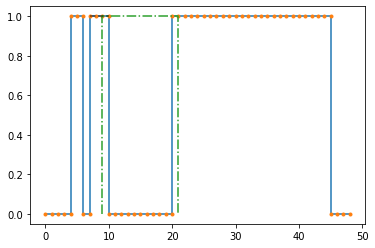

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=3
leading_delta=3


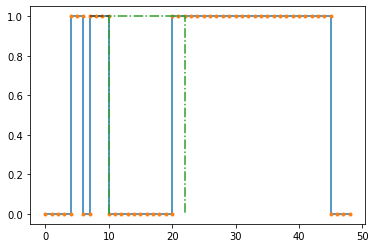

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=3
leading_delta=3


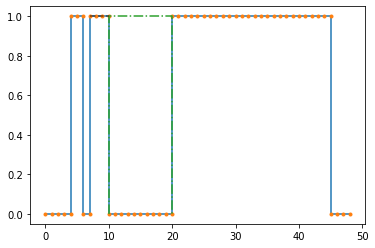

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=4
leading_delta=1


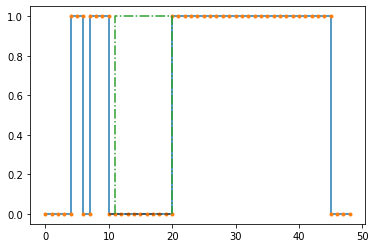

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=5
leading_delta=5


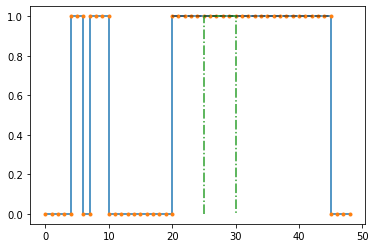

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45])
leading_edge_idx=4
leading_delta=10


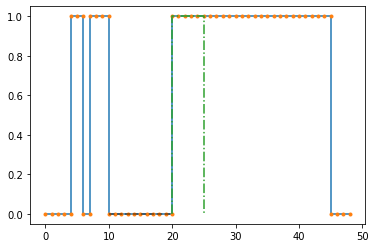

pulse_stream=array([ 4,  2,  1,  3, 10, 25,  3])
cum_sum=array([ 4,  6,  7, 10, 20, 45, 48])
leading_edge_idx=4
leading_delta=10


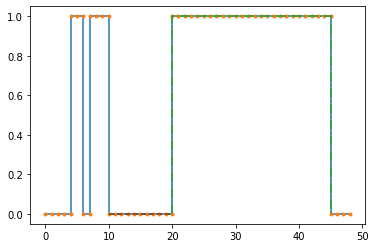

In [67]:
## Insert a pulse into the pulse stream
t_start  = 21
t_width = 3


"""
Cases to verify:

0) New pulse is entirely between existing pulses
1) New pulse overlaps previous pulse
    1') adjacent
2) New pulse overlaps next pulse
    2') adjacent
3) New pulse overlaps both previous and preceeding pulse
    3') adjacent

4) New pulse is entirely contained within existing pulse
    4') adjacent
    *) Pulse train is unchanged
5) Pulse start is beyond scope of current buffer
6) Pulse start is within scope, but stop is beyond scope

7) All cases with either current_state = 0 or current_state = 1

"""


"""
*) directly adjacent edges should be considered overlapping, with 0 width
*)  classify cases based on whether new pulses' rising and falling edges:
        *) lie within existing pulses
        *) lie within dead zones
        *) lie within the same existing pulses
        *) lie within the same dead zone
"""

cases=[]
cases.append( {"t_start" : 12, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" :  9, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" : 10, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" : 18, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" : 15, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" :  9, "t_width" : 12,"current_state" : 0}    )
cases.append( {"t_start" :  10, "t_width" : 12,"current_state" : 0}    )
cases.append( {"t_start" :  10, "t_width" : 10,"current_state" : 0}    )
cases.append( {"t_start" :  11, "t_width" : 9, "current_state" : 0}    )
cases.append( {"t_start" :  25, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" :  20, "t_width" : 5, "current_state" : 0}    )
cases.append( {"t_start" :  20, "t_width" :25, "current_state" : 0}    )


for case in cases:
    
    #unpack the case
    t_start = case["t_start"]
    t_width = case["t_width"]
    current_state = case["current_state"]
    
    #Plot the existsing pulse stream and the desired new pulse
    ts,expanded = expand(pulse_stream,start)
    plt.plot(ts,expanded)
    plt.plot(ts,expanded,".")
    ts_new, expanded_new = expand_new_pulse(t_start,t_width)
    plt.plot(ts_new,expanded_new,"-.") 
    
    #Analyze the partial sums to find where to insert the new pulse
    cum_sum = partial_cum_sum(pulse_stream,t_start,t_width)
    leading_edge_idx=np.argmax(np.where(cum_sum<t_start))
    leading_delta = t_start - cum_sum[leading_edge_idx]
    
    # Add 1 if 
    leading_edge_idx += (leading_delta >= (1-leading_edge_idx%2))
    
    #falling_edge_idx=np.argmax(np.where(cum_sum<(t_start+t_width)))
    
    
    print(f"{pulse_stream=}")
    print(f"{cum_sum=}")
    print(f"{leading_edge_idx=}")
    print(f"{leading_delta=}")
   
    #Compute the edges relevant for classifying the new pulse
    #leading_edge = j-1-j%2
    #trailing_edge = falling_edge_idx
    
    #Plot the regions that the new pulse edges fall within
    plt.hlines(leading_edge_idx%2,xmin=cum_sum[leading_edge_idx-1],xmax=cum_sum[leading_edge_idx],ls="--",color="black",alpha=0.5)
    #plt.vlines(cum_sum[trailing_edge],ymax=1.1,ymin=-0.1,ls="--",color="black",alpha=0.5)
    
    plt.show()
    
    







In [51]:
np.argmax(np.where(cum_sum<t_start))

3

In [ ]:
previous_pulse_end_idx = j-1-((j%2)-1)*start
print(f"{previous_pulse_end_idx=}")
preceeding_gap = t_start-cum_sum[previous_pulse_end_idx]
if preceeding_gap > 0:
    print(f"new pulse begins at {t_start}, which is {preceeding_gap} after the end of the previous pulse ({cum_sum[previous_pulse_end_idx]})")
elif preceeding_gap < -t_width:
    print(f"CASE 5: new_pulse is entirely within existing pulse!")
else:
    print(f"new_pulse begins at {t_start}, which overlaps with previous pulse by {preceeding_gap}")
    
next_pulse_begin_idx = j-(j%2+start)
print(f"{next_pulse_begin_idx=}")
following_gap = cum_sum[next_pulse_begin_idx]-(t_start+t_width)
if following_gap > 0:
    print(f"New pulse ends at {t_start+t_width}, which is {following_gap} before the following pulse begins ({cum_sum[next_pulse_begin_idx]})") 
else:
    print(f"New pulse ends at {t_start+t_width}, which overlaps with the following pulse by {following_gap}")

    
if (preceeding_gap > 0) and (following_gap > 0):
    print("CASE 1: No overlap between new pulse and existing pulses")

elif (preceeding_gap <=0) and (following_gap > 0):
    print("CASE 2: new pulse overlaps previous pulse but not following pulse")

elif (preceeding_gap >0) and (following_gap <=0):
    print("CASE 3: new pulse overlaps following pulse but not previous pulse")

elif (preceeding_gap <=0) and (following_gap<=0):
    print("CASE 4: New pulse bridges two previous pulses")

In [48]:
cum_sum[j]

20